In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones_dendro_dt_0.6/"
# DONOR = 0
# dendroThresh=0.6

#clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'
#clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
#clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"
INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic"
DONOR = 1


# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# DONOR = 1
dendroThresh = "dynamic" #0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACTCGCAAGACACG-1_Input,0_0,0,Input
1,AAAGGGCTCACAGGGA-1_Input,0_0,0,Input
2,AAATGAGAGAGACTCG-1_Input,0_0,0,Input
3,AAATGAGAGCTACGCC-1_Input,0_0,0,Input
4,AACAGTCCACCGAAAG-1_Input,0_0,0,Input
...,...,...,...,...
1436,TACCTCGAGCTATCGT-1_Flt3l,4_5,4,Flt3l
1437,TCAGCTCGTAGTACAA-1_Flt3l,4_5,4,Flt3l
1438,TTAACGGGTGCGTTTA-1_Flt3l,4_5,4,Flt3l
1439,TTACTCATCTGATCCC-1_Flt3l,4_5,4,Flt3l


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,222,0
0_1,112,0
0_10,20,0
0_11,10,0
0_12,9,0
...,...,...
4_1,8,4
4_2,4,4
4_3,7,4


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
mean_af  

Variant,1847A,3106A,7775A,10516A,11382A,13768A,2786C,9899C,11204C,12297C,13034C,16356C,3144G,6047G,2291T,5817T,16296T
lineage,,,,,,,,,,,,,,,,,
1_0,0.002772,0.379397,0.004941,0.004977,0.000778,0.001590,0.007580,0.998958,0.000321,0.000497,0.000547,0.000230,0.000470,0.001476,0.003879,0.002350,0.998551
1_1,0.001690,0.681588,0.015952,0.003608,0.002561,0.001413,0.000735,0.952078,0.000836,0.005930,0.000616,0.006350,0.002606,0.002624,0.005766,0.000400,0.062605
1_10,0.000606,0.565341,0.002169,0.000000,0.000453,0.002183,0.000605,0.953580,0.000000,0.001137,0.001729,0.000996,0.000916,0.002861,0.000000,0.000000,0.998532
1_11,0.001571,0.859626,0.004556,0.000000,0.001034,0.000262,0.000000,0.998234,0.000510,0.002064,0.000723,0.000000,0.001898,0.000976,0.005772,0.004432,0.996164
1_12,0.007500,0.654650,0.005095,0.003448,0.003288,0.003679,0.002667,0.123433,0.000000,0.004851,0.000000,0.009516,0.001646,0.001025,0.001098,0.000555,0.941709
1_13,0.012269,0.637037,0.002473,0.000000,0.000000,0.000000,0.000000,0.994280,0.000000,0.000000,0.000000,0.001802,0.011730,0.001071,0.005597,0.000000,0.999022
1_14,0.000670,0.641290,0.005469,0.000000,0.007617,0.001440,0.000831,0.998421,0.000000,0.000000,0.000000,0.001087,0.000486,0.000365,0.000000,0.001005,0.997894
1_15,0.001055,0.616033,0.006923,0.000000,0.009785,0.000000,0.000000,0.579785,0.000644,0.024465,0.001908,0.015021,0.026858,0.012961,0.002774,0.000000,0.980975
1_16,0.001117,0.810448,0.001962,0.000000,0.000000,0.000000,0.001533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000699,0.002132,0.005630,0.000000,1.000000


In [13]:
# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))

variants_df = vu.type_of_variants(variants_df, to_preproc=False)

In [14]:
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [15]:
mean_af

Variant,1847A,3106A,7775A,10516A,11382A,13768A,2786C,9899C,11204C,12297C,13034C,16356C,3144G,6047G,2291T,5817T,16296T
lineage,,,,,,,,,,,,,,,,,
1_0,0.002772,0.379397,0.004941,0.004977,0.000778,0.001590,0.007580,0.998958,0.000321,0.000497,0.000547,0.000230,0.000470,0.001476,0.003879,0.002350,0.998551
1_1,0.001690,0.681588,0.015952,0.003608,0.002561,0.001413,0.000735,0.952078,0.000836,0.005930,0.000616,0.006350,0.002606,0.002624,0.005766,0.000400,0.062605
1_10,0.000606,0.565341,0.002169,0.000000,0.000453,0.002183,0.000605,0.953580,0.000000,0.001137,0.001729,0.000996,0.000916,0.002861,0.000000,0.000000,0.998532
1_11,0.001571,0.859626,0.004556,0.000000,0.001034,0.000262,0.000000,0.998234,0.000510,0.002064,0.000723,0.000000,0.001898,0.000976,0.005772,0.004432,0.996164
1_12,0.007500,0.654650,0.005095,0.003448,0.003288,0.003679,0.002667,0.123433,0.000000,0.004851,0.000000,0.009516,0.001646,0.001025,0.001098,0.000555,0.941709
1_13,0.012269,0.637037,0.002473,0.000000,0.000000,0.000000,0.000000,0.994280,0.000000,0.000000,0.000000,0.001802,0.011730,0.001071,0.005597,0.000000,0.999022
1_14,0.000670,0.641290,0.005469,0.000000,0.007617,0.001440,0.000831,0.998421,0.000000,0.000000,0.000000,0.001087,0.000486,0.000365,0.000000,0.001005,0.997894
1_15,0.001055,0.616033,0.006923,0.000000,0.009785,0.000000,0.000000,0.579785,0.000644,0.024465,0.001908,0.015021,0.026858,0.012961,0.002774,0.000000,0.980975
1_16,0.001117,0.810448,0.001962,0.000000,0.000000,0.000000,0.001533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000699,0.002132,0.005630,0.000000,1.000000


In [16]:
if mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 :
    print('no clustering needed only one var')
else:
    g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    curr_clones = curr_clones.iloc[inds]
    plt.close(g.fig)

### Cluster and calculate proper size

In [17]:
%matplotlib inline
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):

    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic(mean_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)

    else:
        den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))

    curr_clones


distances
[0.98477 0.19169 0.48034 0.91963 0.25830 0.26216 0.48354 1.08803 0.37074
 1.06748 0.32317 0.99338 0.12730 0.09990 0.39334 1.04246 0.24780 0.36976
 0.16144 1.03535 0.41911 1.02447 1.02743 0.36439 1.02142 1.02547 0.43684
 1.09646 0.47024 1.09144 1.08189 1.08525 0.22072 0.94328 0.95162 1.20847
 0.93867 0.93744 0.99377 1.34241 0.94120 1.33652 0.93794 1.36625 0.95521
 0.95740 0.94232 1.33414 0.93331 0.93986 0.94847 1.30160 0.94532 1.33713
 1.33637 0.94030 1.33923 1.33810 0.94826 1.20838 0.95282 1.33375 1.34023
 1.34174 0.94027 0.29778 0.83697 0.08423 0.08862 0.37979 0.98460 0.19047
 0.97217 0.14650 0.96730 0.06738 0.09531 0.21263 0.95910 0.07325 0.18563
 0.04302 0.95933 0.23795 0.95451 0.95486 0.18436 0.95398 0.95471 0.25492
 0.99833 0.27913 0.98691 0.98063 0.98286 0.05941 0.90026 0.22319 0.21857
 0.48608 0.99947 0.11005 1.00310 0.16074 1.10555 0.36379 0.38148 0.08855
 1.01205 0.23431 0.11264 0.32020 1.02437 0.06283 1.02987 1.02591 0.11620
 1.03348 1.02885 0.05262 1.01931 0.13343 

## Group clones using dendrogram and run stats on size differences in the groups

### Run ranksums on clone size btwn debdrogram clusters

In [18]:
# size_pvals = []
# for pair in combinations(curr_clones["den_clust"].unique(),2):
#     print(pair)
#     stat, p_val = scipy.stats.ranksums(curr_clones.loc[curr_clones["den_clust"]==pair[0], "size"].values, 
#                          y=curr_clones.loc[curr_clones["den_clust"]==pair[1], "size"].values, 
#                          alternative='two-sided')

#     size_pvals.append(f"{pair[0]}, {pair[1]}, {str(p_val)}")
    


## Plot with dendro clusters

In [19]:
conditions = cells_meta["condition"].unique()

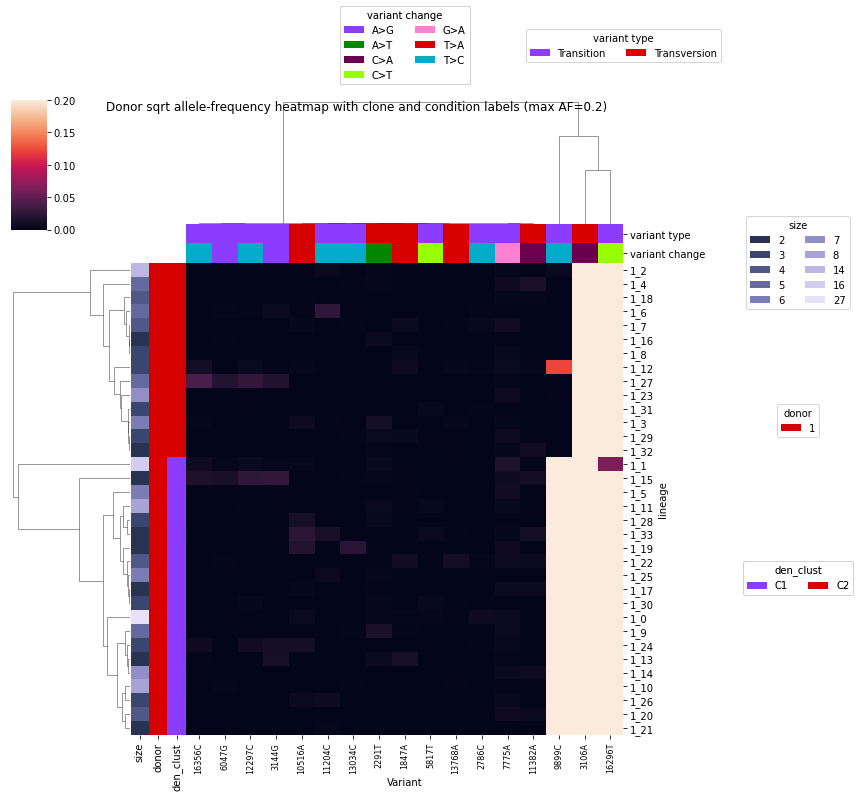

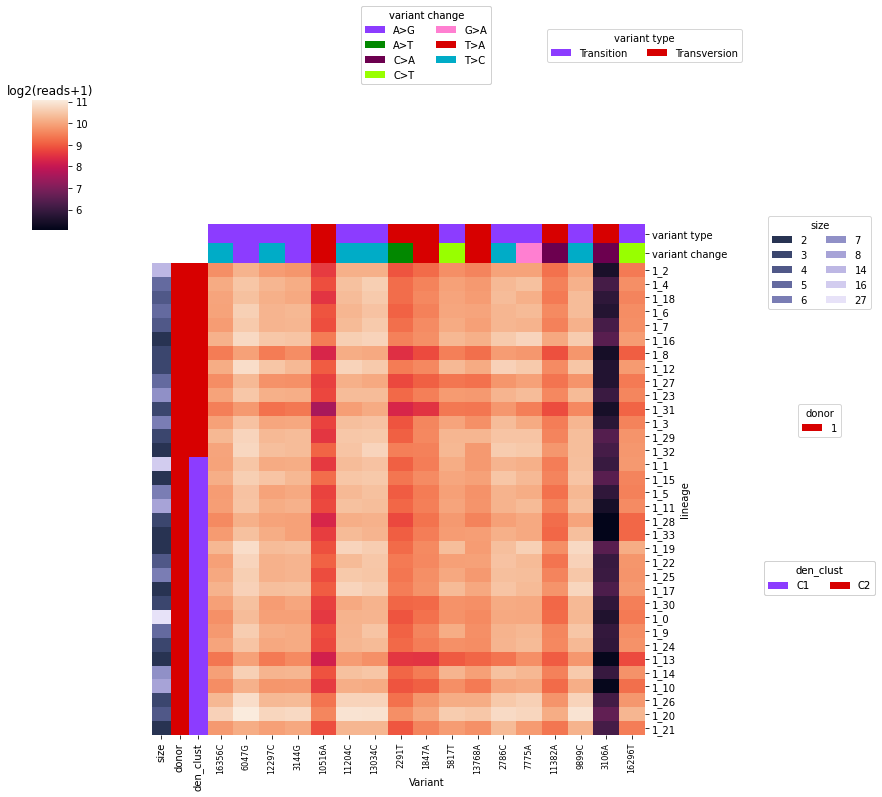

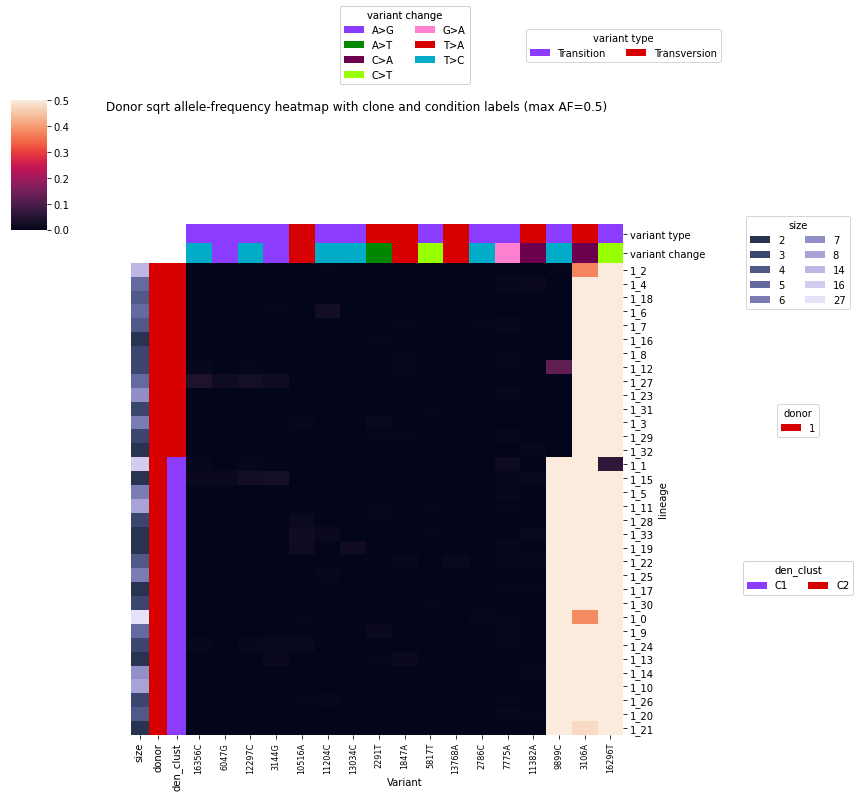

In [20]:
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                        col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                        row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                        vmax=0.2, vmin=0)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=False)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f+".dendro.NoCondition.DP.png")#, f=g1d.figure)


    mean_af = mean_af.iloc[inds,cols]
    curr_clones = curr_clones.loc[mean_af.index]

    ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.5, vmin=0)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=False)



In [21]:
out_f

'/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic/donor1'

### Save mean_af and curr_clonnes

In [22]:

mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")